In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.0 MB/s eta 0:00:00


In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re

C1true = 1.0
C2true = 0.01

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



In [6]:
# load the training data

def load_training_data(num):
  data = loadmat("cylinder_nektar_wake.mat")
  #print(data)

  U_star = data["U_star"] #N X 2 X T
  P_star = data["p_star"] #N X T
  t_star = data["t"]  # T
  X_star = data["X_star"] # N X 2

  # print("p_star.shape",P_star.shape)
  # print("p_star",P_star)

  N = X_star.shape[0]
  T = t_star.shape[0]

  XX = np.tile(X_star[:,0:1], (1,T))
  YY = np.tile(X_star[:,1:2], (1,T))
  TT = np.tile(t_star, (1,N)).T # 5000*200 = 1000000
  UU = U_star[:, 0, :] # velocity
  VV = U_star[:, 1, :] #
  PP = P_star

  # print("VV.shape",VV.shape)
  # print("VV",VV)

  x = XX.flatten()[:, None] # NT x 1
  y = YY.flatten()[:, None]
  t = TT.flatten()[:, None]
  u = UU.flatten()[:, None]
  v = VV.flatten()[:, None]
  p = PP.flatten()[:, None]
  # print("u.shape",u.shape)
  # print("u",u)
  # print("x.shape",x.shape)
  # print("x",u)
  # print("t.shape",t.shape)
  # print("t",t)

  data1 = np.concatenate([x,y,t,u,v,p], 1)
  # print("data1.shape",data1.shape)
  # print("data1",data1)

  # computational domain will be X * Y = [1,8] * [-2,2], time = [0,7]
  data2 = data1[:,:][data1[:,2] <= 7]
  data3 = data2[:,:][data2[:,0] >= 1]
  data4 = data3[:,:][data3[:,0] <= 8]
  data5 = data4[:,:][data4[:,1] >= -2]
  data6 = data5[:,:][data5[:,1] <= 2]

  data_domain = data6
  # print("data_domain.shape",data_domain.shape)
  # print("data_domain",data_domain)

  idx = np.random.choice(data_domain.shape[0], num, replace=False)
  print("idx: ", idx)

  x_train = data_domain[idx, 0:1]
  y_train = data_domain[idx, 1:2]
  t_train = data_domain[idx, 2:3]
  u_train = data_domain[idx, 3:4]
  v_train = data_domain[idx, 4:5]
  p_train = data_domain[idx, 5:6]


  return [x_train, y_train, t_train, u_train, v_train, p_train]


In [10]:
[ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num = 7000)

# print("ob_x: ", ob_x)
# print("ob_y: ", ob_y)
# print("ob_y.shape: ", ob_y.shape)
# print("ob_u: ", ob_u)
# print("ob_v: ", ob_v)
# print("ob_p: ", ob_p)

ob_xyt = np.hstack((ob_x,ob_y,ob_t)) # input of the neural network
print("ob_xyt.shape: ", ob_xyt.shape)
print("ob_xyt: ", ob_xyt)


idx:  [294476 115669 289746 ... 164744 279194 219265]
ob_xyt.shape:  (7000, 3)
ob_xyt:  [[ 4.32323232  1.34693878  3.9       ]
 [ 3.05050505 -0.69387755  1.        ]
 [ 6.65656566  1.26530612  6.6       ]
 ...
 [ 2.41414141 -0.12244898  2.4       ]
 [ 3.26262626  1.18367347  2.2       ]
 [ 7.22222222  0.44897959  1.7       ]]


In [12]:
C1 = dde.Variable(0.0)
C2 = dde.Variable(0.0)

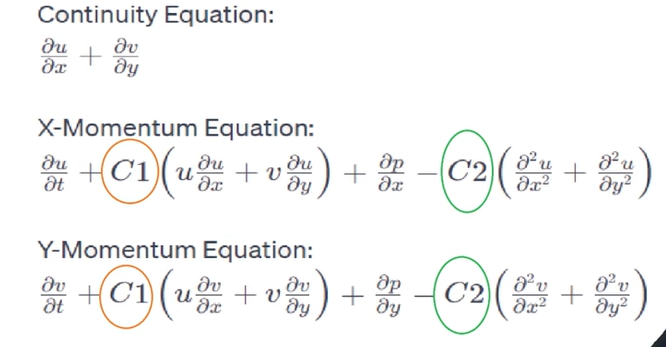

In [13]:
def Navier_Stokes_Eq(x,y):
  u = y[:, 0:1]
  v = y[:, 1:2]
  p = y[:, 2:3]


  du_x = dde.grad.jacobian(y, x, i=0, j=0)
  du_y = dde.grad.jacobian(y, x, i=0, j=1)
  du_t = dde.grad.jacobian(y, x, i=0, j=2)

  dv_x = dde.grad.jacobian(y, x, i=1, j=0)
  dv_y = dde.grad.jacobian(y, x, i=1, j=1)
  dv_t = dde.grad.jacobian(y, x, i=1, j=2)

  dp_x = dde.grad.jacobian(y, x, i=2, j=0)
  dp_y = dde.grad.jacobian(y, x, i=2, j=1)

  du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
  du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)

  dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
  dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

  continuity = du_x + dv_y
  x_momentum = du_t + C1 * (u * du_x + v * du_y) + dp_x - C2 * (du_xx + du_yy)
  y_momentum = dv_t + C1 * (u * dv_x + v * dv_y) + dp_y - C2 * (dv_xx + dv_yy)

  return [continuity, x_momentum, y_momentum]

In [14]:
# define the DNN
layer_size = [3] + [50] * 6 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [15]:
Lx_min, Lx_max = 1.0, 8.0
Ly_min, Ly_max = -2.0, 2.0

space_domain = dde.geometry.Rectangle([Lx_min,Ly_min], [Lx_max,Ly_max])

time_domain = dde.geometry.TimeDomain(0,7)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

In [16]:
observe_u = dde.icbc.PointSetBC(ob_xyt, ob_u, component=0)
observe_v = dde.icbc.PointSetBC(ob_xyt, ob_v, component=1)
observe_p = dde.icbc.PointSetBC(ob_xyt, ob_p, component=2)

In [17]:
# Training dataset used to calculate the loss
data = dde.data.TimePDE(
    geomtime,
    Navier_Stokes_Eq,
    [observe_u, observe_v, observe_p],
    num_domain=700,
    num_boundary=200,
    num_initial=100,
    anchors=ob_xyt
)

Compiling model...
'compile' took 1.399954 s

Training model...

0         [1.83e-02, 9.54e-03, 2.75e-03, 1.25e+00, 1.86e-01, 5.09e-01]    [1.83e-02, 9.54e-03, 2.75e-03, 1.25e+00, 1.86e-01, 5.09e-01]    []  
1000      [7.25e-04, 1.59e-03, 1.26e-03, 3.27e-03, 5.64e-03, 1.29e-03]    [7.25e-04, 1.59e-03, 1.26e-03, 3.27e-03, 5.64e-03, 1.29e-03]    []  
2000      [4.25e-04, 6.36e-04, 8.31e-04, 2.32e-03, 2.04e-03, 3.54e-04]    [4.25e-04, 6.36e-04, 8.31e-04, 2.32e-03, 2.04e-03, 3.54e-04]    []  
3000      [2.62e-04, 4.64e-04, 3.82e-04, 9.51e-04, 1.36e-03, 2.26e-04]    [2.62e-04, 4.64e-04, 3.82e-04, 9.51e-04, 1.36e-03, 2.26e-04]    []  
4000      [2.16e-04, 3.84e-04, 2.78e-04, 7.16e-04, 9.47e-04, 1.56e-04]    [2.16e-04, 3.84e-04, 2.78e-04, 7.16e-04, 9.47e-04, 1.56e-04]    []  
5000      [1.84e-04, 2.86e-04, 2.10e-04, 5.09e-04, 6.38e-04, 1.03e-04]    [1.84e-04, 2.86e-04, 2.10e-04, 5.09e-04, 6.38e-04, 1.03e-04]    []  
6000      [1.45e-04, 2.21e-04, 1.69e-04, 3.63e-04, 4.24e-04, 6.15e-05]    [1.

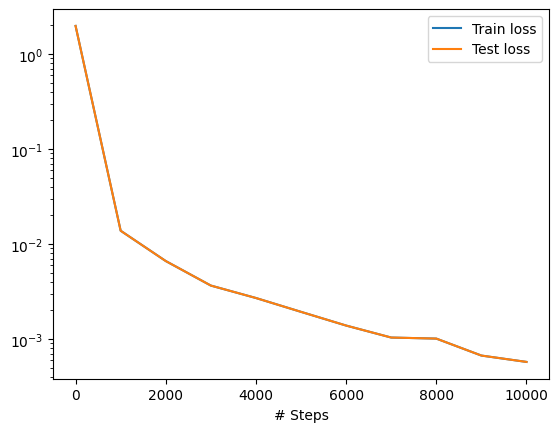

Compiling model...
'compile' took 1.617130 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
10000     [5.90e-05, 1.18e-04, 9.35e-05, 1.52e-04, 1.30e-04, 2.03e-05]    [5.90e-05, 1.18e-04, 9.35e-05, 1.52e-04, 1.30e-04, 2.03e-05]    []  
11000     [5.26e-05, 1.05e-04, 8.13e-05, 1.30e-04, 1.08e-04, 1.60e-05]    [5.26e-05, 1.05e-04, 8.13e-05, 1.30e-04, 1.08e-04, 1.60e-05]    []  
12000     [4.78e-05, 9.32e-05, 7.15e-05, 1.14e-04, 9.44e-05, 1.37e-05]    [4.78e-05, 9.32e-05, 7.15e-05, 1.14e-04, 9.44e-05, 1.37e-05]    []  
13000     [4.43e-05, 8.34e-05, 6.38e-05, 1.01e-04, 8.32e-05, 1.18e-05]    [4.43e-05, 8.34e-05, 6.38e-05, 1.01e-04, 8.32e-05, 1.18e-05]    []  
14000     [4.14e-05, 7.57e-05, 5.73e-05, 9.06e-05, 7.46e-05, 1.05e-05]    [4.14e-05, 7.57e-05, 5.73e-05, 9.06e-05, 7.46e-05, 1.05e-05]    []  
15000     [3.88e-05, 6.94e-05, 5.23e-05, 8.16e-05, 6.78e-05, 9.43e-06]

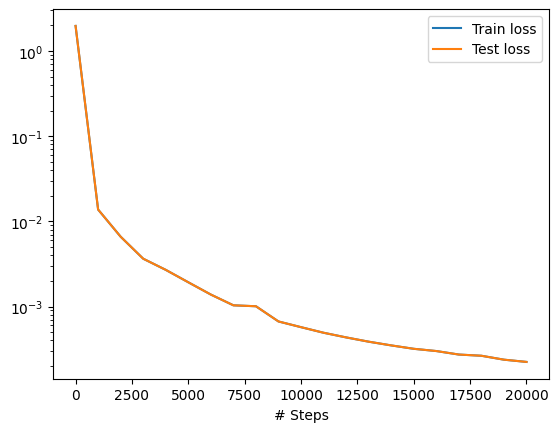

Mean residual:  0.004347895


In [21]:
model = dde.Model(data, net)

results_file_C1_C2 = "variables_main_C1_C2.dat"
variable = dde.callbacks.VariableValue([C1,C2], period = 100, filename= results_file_C1_C2)

model.compile("adam", lr=1e-3, external_trainable_variables=[C1,C2])
loss_history, train_state= model.train(iterations=10000, callbacks=[variable],display_every=1000,disregard_previous_best= True)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

model.compile("adam", lr=1e-4, external_trainable_variables=[C1,C2])
loss_history, train_state= model.train(iterations=10000, callbacks=[variable],display_every=1000,disregard_previous_best= True)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

f = model.predict(ob_xyt, operator=Navier_Stokes_Eq)
print("Mean residual: ", np.mean(np.absolute(f)))

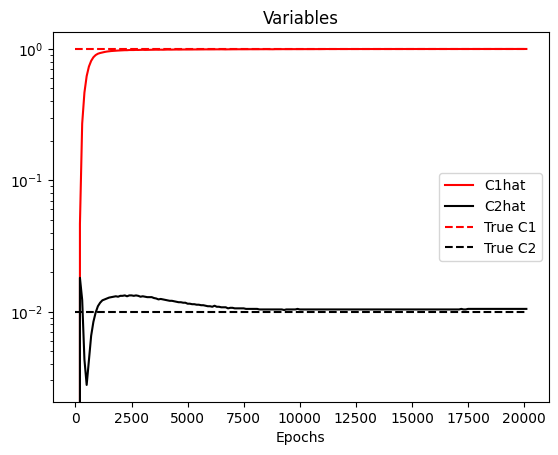

In [22]:
# Plot Variables:
# reopen saved data using callbacks in results_file_C1_C2

results_file_C1_C2 = "variables_main_C1_C2.dat"
lines = open(results_file_C1_C2, "r").readlines()
# read output data in fnamevar
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
l, c = Chat.shape
plt.semilogy(range(0, l * 100, 100), Chat[:, 0], "r-")
plt.semilogy(range(0, l * 100, 100), Chat[:, 1], "k-")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 0].shape) * C1true, "r--")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 1].shape) * C2true, "k--")
plt.legend(["C1hat", "C2hat", "True C1", "True C2"], loc="right")
plt.xlabel("Epochs")
plt.title("Variables")
plt.show()

idx:  [277242 224474 344878 ... 272389  31298 104429]


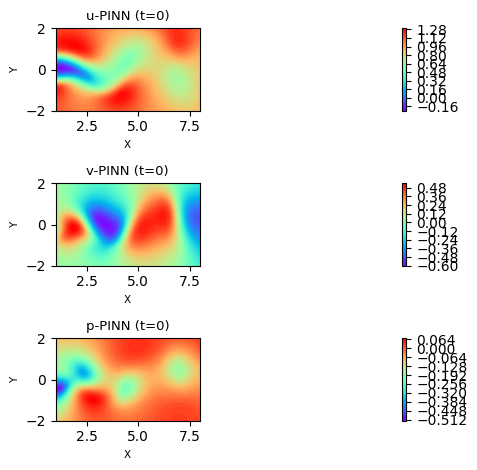

idx:  [184457 265924 247675 ... 229284 339821 245561]


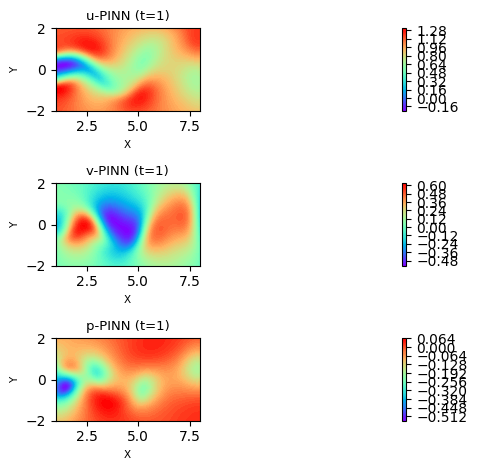

idx:  [ 37630  97913 108565 ... 233296 260744 205489]


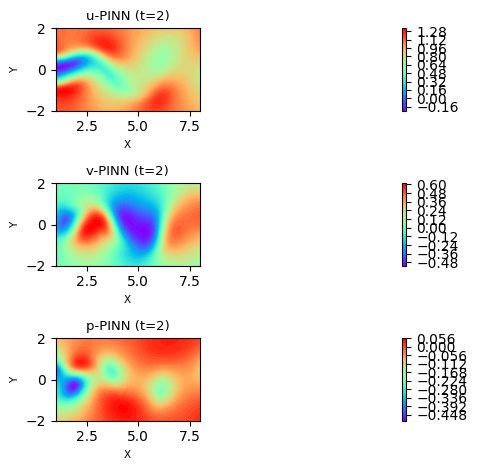

idx:  [266910  44656 340166 ...  18238  89717 204583]


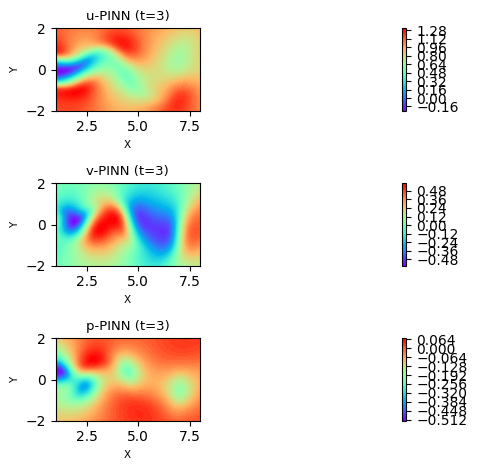

idx:  [279766 334990 295540 ... 221680 232259 221627]


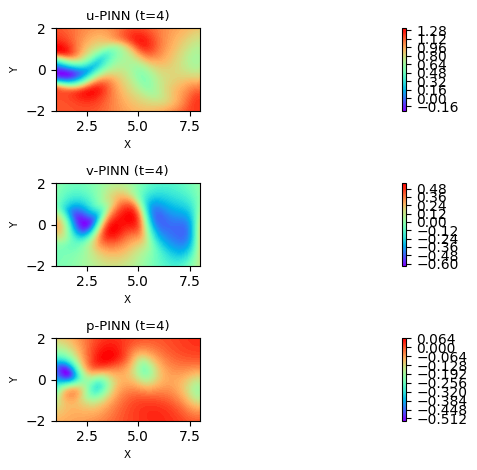

idx:  [347978  58825 138659 ...  60079  10002 218049]


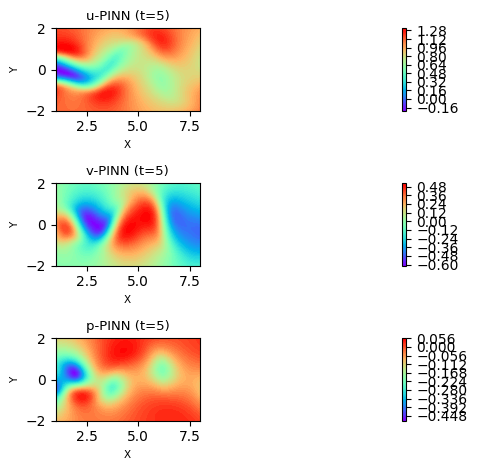

idx:  [320981 321254 288041 ...  48180  51780 320229]


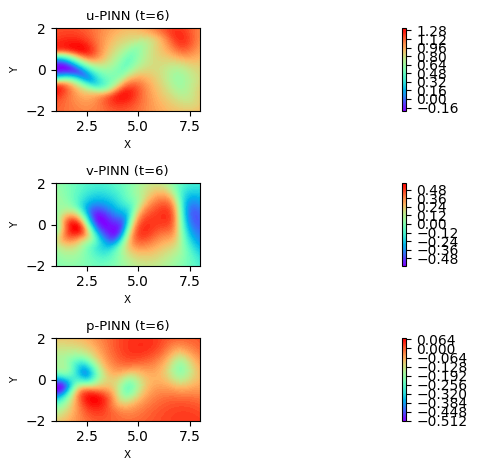

idx:  [327220  16746 243330 ...  40915 168789 231816]


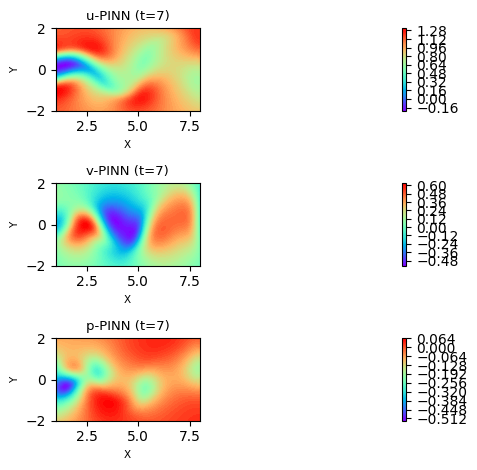

In [23]:
# Plot the velocity and pressure distribution of the flow field:
for t in range(0, 8):
    [ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=140000)
    xyt_pred = np.hstack((ob_x, ob_y, t * np.ones((len(ob_x), 1))))
    uvp_pred = model.predict(xyt_pred)
    x_pred, y_pred, t_pred = xyt_pred[:, 0], xyt_pred[:, 1], xyt_pred[:, 2]
    u_pred, v_pred, p_pred = uvp_pred[:, 0], uvp_pred[:, 1], uvp_pred[:, 2]
    x_true = ob_x[ob_t == t]
    y_true = ob_y[ob_t == t]
    u_true = ob_u[ob_t == t]
    p_true = ob_p[ob_t == t]  # Extract pressure values
    fig, ax = plt.subplots(3, 1)  # Create three subplots
    # Velocity subplot
    cntr0 = ax[0].tricontourf(x_pred, y_pred, u_pred, levels=80, cmap="rainbow")
    cb0 = plt.colorbar(cntr0, ax=ax[0])
    cntr1 = ax[1].tricontourf(x_pred, y_pred, v_pred, levels=80, cmap="rainbow")
    cb1 = plt.colorbar(cntr1, ax=ax[1])
    # Pressure subplot
    cntr2 = ax[2].tricontourf(x_pred, y_pred, p_pred, levels=80, cmap="rainbow")
    cb2 = plt.colorbar(cntr2, ax=ax[2])
    ax[0].set_title("u-PINN " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[1].set_title("v-PINN " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[2].set_title("p-PINN " + "(t=" + str(t) + ")", fontsize=9.5)  # Title for pressure subplot
    for i in range(3):
        ax[i].axis("scaled")
        ax[i].set_xlabel("X", fontsize=7.5, family="Arial")
        ax[i].set_ylabel("Y", fontsize=7.5, family="Arial")
    fig.tight_layout()
    plt.show()